# Prueba 2: Analizado los crímenes en la Ciudad de Nueva York

En esta ocasión trabajaremos con datos públicos del departamento de policía de New York. El dataset es llamado stop_and_frisk_data y contiene información sobre interrogaciones y detenciones realizadas por le departamento de policia de NY en la vía pública. El diccionario de atributos se encuentra en el archivo 2009 SQF File Spec.xlsx.

Para todo nuestro estudio utilizaremos los datos correspondientes al año 2009 como conjunto de entrenamiento y los datos del 2010 como conjunto de pruebas. Hay que hacer notar que los datos que estamos utilizando son un muestreo del  de la cantidad de registros reales que contiene el dataset, esta decisión fue tomada debido a los largos tiempos de entrenamiento y procesamiento que requiere el volumén de datos reales.

* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook, archivos auxiliares y csv). 
* Una vez terminada la prueba, comprime la carpeta y sube el .zip a la sección correspondiente.

## Hito 1: Preliminares y aspecto computacionales

El problema presentado es un problema de clasificación, donde se debe generar un modelo que sea capaz de predecir según los atributos de un sospechoso, si el individuo será arrestado o no durante un procedimiento.

Debido a que se cuenta con los conjuntos de entrenamiento y validación se utilizarán los siguientes modelos de clasificación supervisados:

* Regresión Logistica
* Análisis Lineal Discriminante (LDA)
* Maquinas de soporte vectorial (SVM)
* Boosting Machines (GradientBoosting)
* Voting

Se deben tener las siguientes consideraciones:

Datos perdidos: Determinar porcentaje de datos perdidos por atributo y en función de esto se determina si la variable se considera en el analisis o no.

Estandarización : La data debe seguir un formato estándar para su análisis. Por ejemplo, números almacenados como strings se transformarán a valores numéricos, datos perdidos tendrán una sola notación, etc.

Binarización : Se binarizarán variables categóricas o se determinarán valores discretos estándar.

Respecto a los aspectos computacionales, se considerará el uso de Gridsearch y Pipeline, para optimizar la busqueda de los mejores parámetros del modelo .

Adicionalmente se utilizarán las siguientes métricas:

* Reporte de clasificación con métricas de precision, recall y f1 score
* Curva ROC.

A continuación se importan las librerías necesarias y se detalla su función en el procesamiento de los datos.

In [1]:
# Se importan las librerías básicas para la lectura de la base de datos
import pandas as pd                                                               ## v1.4.4
import numpy as np                                                                ## v1.23.5
import seaborn as sns                                                             ## v0.12.1
import matplotlib.pyplot as plt                                                   ## v3.6.2

# Se importa en caso de que sea necesario ver de forma gráfica la
#frecuencia de datos nulos
import missingno as msgno ## v0.5.1

# Modulo creado en visual code que contiene funciones 
#definidas para ayudar en el preprocesamiento, recodificación y el 
#analisis de variables discretas y continuas.
import preproc_nyc_sqf as pre
import helpers as hlp

# Módulo necesario para el preprocesamiento de los datos
#y que contiene las métricas de evaluación necesarias para validar los modelos
from sklearn.model_selection import train_test_split as TTS                       ## v1.0.2
from sklearn.model_selection import cross_val_score                               ## v1.0.2
from sklearn.linear_model import LogisticRegression                               ## v1.0.2
from sklearn.pipeline import Pipeline                                             ## v1.0.2
from sklearn.model_selection import GridSearchCV                                  ## v1.0.2
from sklearn.linear_model import LogisticRegression                               ## v1.0.2
from sklearn.ensemble import VotingClassifier                                     ## v1.0.2
from sklearn.ensemble import GradientBoostingClassifier                           ## v1.0.2
from sklearn.svm import SVC                                                       ## v1.0.2
from sklearn.ensemble import RandomForestClassifier                               ## v1.0.2
import sklearn.metrics as metricas                                                ## v1.0.2
from sklearn.metrics import classification_report, roc_curve                      ## v1.0.2

# Modulo utilizado para ahorrar espacio en el notebook quitando las advertencias
#innecesarias
import warnings
warnings.simplefilter("ignore")


In [2]:
df_2009 = pd.read_csv("2009_1perc.csv").drop("Unnamed: 0", axis=1)
df_2009

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
0     2009   41     1779   4032009       130       A     O       P     1.0   
1     2009  108     5805  10292009      1050       A     O       P     3.0   
2     2009   43     8340  10062009      1450       1     O       P     1.0   
3     2009   77      932   1232009      1843       A     O       P     5.0   
4     2009  110    11224  12132009      1655       A     O       P     3.0   
...    ...  ...      ...       ...       ...     ...   ...     ...     ...   
5807  2009   52     3719   3282009       210       A     O       P     1.0   
5808  2009   79    15751   9292009      2008       A     O       P     3.0   
5809  2009   69     3024   6262009      1937       1     O       P     1.0   
5810  2009   76     1303   3102009        59       1     O       H     1.0   
5811  2009   10     1018   5142009        40       1     O       H     5.0   

               crimsusp  ...  zip addrpct sector beat post   xcoord   ycoord  \
0                   CPW  ...           41      G    7       1013067  0238633   
1                  BURG  ...          108      J            1012043  0212157   
2                  MISD  ...           43      E            1017599  0240200   
3                   MIS  ...           77      J    4   35  1002625  0183442   
4                   CPW  ...          110      H            1024535  0209890   
...                 ...  ...  ...     ...    ...  ...  ...      ...      ...   
5807            ASSAULT  ...           52      A            1009910  0255837   
5808                CPW  ...           79      F   17       1001545  0192836   
5809                FEL  ...           69      B            1012860  0174682   
5810  CPM MISD  PSA#771  ...           76      A   10       0981820  0185424   
5811               CPCS  ...           10      D            0984003  0212087   

     dettypcm  linecm  detailcm  
0          CM       1        20  
1          CM       1        14  
2          CM       1        20  
3          CM       1        24  
4          CM       1        20  
...       ...     ...       ...  
5807       CM       1         9  
5808       CM       1        20  
5809       CM       1        85  
5810       CM       1        27  
5811       CM       1        24  

[5812 rows x 111 columns]

In [3]:
df_2010 = pd.read_csv("2010_1perc.csv").drop("Unnamed: 0",axis=1)
df_2010

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
0     2010    6      487   1192010      1420       1     O       P       2   
1     2010   42     7138   9042010       225       1     I       T      10   
2     2010   33     2628   6302010      1240       1     I       T       5   
3     2010  108     6384  11172010      2338       1     O       P       3   
4     2010   14     2295   3072010      2240       1     I       T       5   
...    ...  ...      ...       ...       ...     ...   ...     ...     ...   
6008  2010   60     7062   9262010        45       1     O       H       2   
6009  2010   75    15797   7302010        10       A     O       P       1   
6010  2010  123      830   4302010      1630       A     O       P       3   
6011  2010  115    13122  11232010      2100       1     O       P       1   
6012  2010   14      219   1062010      1406       1     I       T       4   

       crimsusp  ...  zip addrpct sector beat post   xcoord  ycoord dettypcm  \
0           FEL  ...            6      G        38   983543  208767       CM   
1        FELONY  ...           42      E            1014172  241737       CM   
2       ROBBERY  ...           33      B    6       1000916  245710       CM   
3          CSCS  ...          108      J            1012612  212240       CM   
4     MISD/ CPW  ...           14      C    7        987636  212439       CM   
...         ...  ...  ...     ...    ...  ...  ...      ...     ...      ...   
6008       MISD  ...           60      I             989382  155162       CM   
6009    ROBBERY  ...           75      A            1012757  186018       CM   
6010        GLA  ...          123      E             933868  138600       CM   
6011     FELONY  ...          115      E            1014722  214388       CM   
6012  CRIM MIS.  ...           14      H   11        987078  215157       CM   

      linecm  detailcm  
0          1        85  
1          1        45  
2          1        85  
3          1        28  
4          1        20  
...      ...       ...  
6008       1        20  
6009       1        85  
6010       1        46  
6011       1        85  
6012       1        23  

[6013 rows x 111 columns]

* **Se debe analizar el comportamiento del vector objetivo.**

De acuerdo a la lista entregada, el vector objetivo será `WAS AN ARREST MADE?` en la columna `"arstmade"`. Realizamos un análisis rápido para evaluar la distribución y balance de los datos con value_counts()

   arstmade
N      5464
Y       348


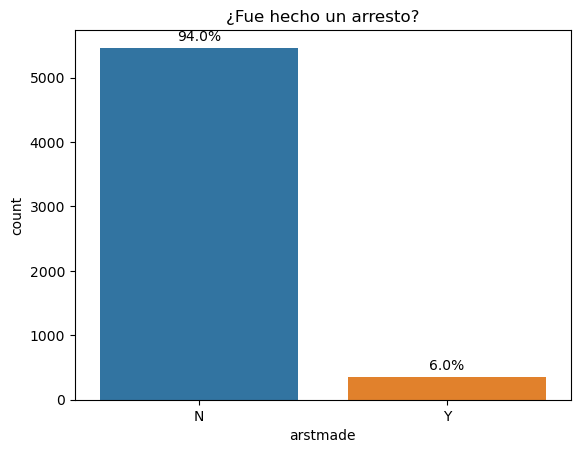

In [4]:
print(df_2009["arstmade"].value_counts().to_frame())

ax = sns.countplot(x=df_2009["arstmade"])
for p in ax.patches:
    height = p.get_height()
    ax.annotate("{:.1f}%".format(height*100/df_2009["arstmade"].shape[0]),
                xy=(p.get_x()+p.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va="bottom")
plt.title("¿Fue hecho un arresto?");

Se puede ver un gran desbalance en los datos, entre cuando se realizó un arresto y cuando No.

* **Se estudia el patrón de datos perdidos:**

Este código devuelve una lista de los nombres de las columnas de un marco de datos (df_2009) que contienen valores faltantes (NaN). Esto se logra primero obteniendo una matriz booleana que indica si hay valores faltantes en cada columna, luego seleccionando los nombres de las columnas correspondientes a las columnas con valores faltantes y finalmente convirtiendo la selección en una lista.

In [5]:
# df_2009.columns[df_2009.isna().any()].tolist()
df_2009.isnull().sum().sort_values(ascending=True)

year        0
race        0
sex         0
offshld     0
offverb     0
           ..
othrweap    0
machgun     0
knifcuti    0
pf_other    0
detailcm    0
Length: 111, dtype: int64

In [6]:
df_2010.isnull().sum().sort_values(ascending=True)

year        0
offshld     0
offverb     0
rf_bulg     0
rf_furt     0
           ..
knifcuti    0
asltweap    0
pf_pepsp    0
premname    1
stinter     1
Length: 111, dtype: int64

A priori no existen valores nulos en el Dataframe, sin embargo eso no implica que puedan estar ingresados con otra codificación. Esto se verá cuando se estudie la distribución y comportamiento de cada variable.

**1. Definir el tipo de modelo a implementar para generar una predicción de arresto, así como su grilla de hiperparámetros.**

**LogisticRegression**
```python
    C: [0.01,0.1,1,10,100]
    fit_intercept: [True, False]
```
**Grilla Maquinas de Soporte Vectorial**
```python
    C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    gamma: [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
    Validaciones cruzadas: 3
```

**Random Forest**
```python
    n_estimators : range(20,1000,50)
    max_features : None , log2 , sqrt 
```
**Boosting Machine**
```python
    learning_rate: [0.01, 0.1, 0.5],
    n_estimators: [50, 100, 500, 1000, 2000]
    subsample: [0.1,0.5,0.9]
```

**Estimadores Voting**

```python
    estimators = [("Logistic Regression", LogisticRegression()),
                  ("SVM", SVC()),
                  ("Random Forest", RandomForestClassifier()),
                  ("Boosting Machine", GradientBoosting())]
```

**2. Definir la recodificación del vector objetivo para generar una predicción de acción violenta en el procedimiento.**

Se genera el vector objetivo que define si el asalto realizado es violento o no. Esto, de acuerdo a los atributos correspondientes

In [7]:
arst_Y = ["pf_hands", "pf_grnd", "pf_drwep", "pf_baton", "pf_hcuff", "pf_pepsp", "pf_other", "pf_wall"]

df_2009["violent_obj"] = np.where((df_2009[arst_Y] == "Y").any(axis=1), 1 , 0)
df_2009["violent_obj"].value_counts()
print(df_2009["violent_obj"].value_counts().to_frame())
violent_atrib_2009 = df_2009[arst_Y + ["violent_obj"]]
violent_atrib_2009

   violent_obj
0         4363
1         1449


pf_hands pf_grnd pf_drwep pf_baton pf_hcuff pf_pepsp pf_other pf_wall  \
0           N       N        N        N        N        N        N       N   
1           N       N        N        N        N        N        N       N   
2           N       N        N        N        N        N        N       N   
3           N       N        N        N        N        N        N       N   
4           N       N        N        N        N        N        N       N   
...       ...     ...      ...      ...      ...      ...      ...     ...   
5807        N       N        N        N        N        N        N       N   
5808        Y       N        N        N        N        N        N       N   
5809        N       N        N        N        N        N        N       N   
5810        N       N        N        N        Y        N        N       N   
5811        N       N        N        N        N        N        N       N   

      violent_obj  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
5807            0  
5808            1  
5809            0  
5810            1  
5811            0  

[5812 rows x 9 columns]

In [8]:
df_2010["violent_obj"] = np.where((df_2010[arst_Y] == "Y").any(axis=1), 1 , 0)
print(df_2010["violent_obj"].value_counts().to_frame())
violent_atrib_2010 = df_2010[arst_Y + ["violent_obj"]]
violent_atrib_2010

   violent_obj
0         4563
1         1450


pf_hands pf_grnd pf_drwep pf_baton pf_hcuff pf_pepsp pf_other pf_wall  \
0           N       N        N        N        N        N        N       N   
1           N       N        N        N        N        N        N       N   
2           N       N        N        N        N        N        N       Y   
3           N       N        N        N        N        N        N       N   
4           N       N        N        N        N        N        N       N   
...       ...     ...      ...      ...      ...      ...      ...     ...   
6008        Y       N        N        N        N        N        N       N   
6009        N       N        N        N        N        N        N       N   
6010        N       N        N        N        N        N        N       N   
6011        Y       N        N        N        N        N        N       N   
6012        N       N        N        N        N        N        N       N   

      violent_obj  
0               0  
1               0  
2               1  
3               0  
4               0  
...           ...  
6008            1  
6009            0  
6010            0  
6011            1  
6012            0  

[6013 rows x 9 columns]

In [9]:
violent_atrib_2009 = df_2009[["pf_hands", "pf_wall", "pf_grnd", "pf_drwep", "pf_baton", "pf_hcuff", "pf_pepsp", "pf_other", "violent_obj"]]

**3. Implementar el script preproc_nyc_sqf.py para igualar la cantidad de atributos en el benchmark.**

Importamos el archivo `preproc_nyc_sqf` y ejecutamos la funcion `create_suitable_dataframe`, donde de acuerdo a la documentación, *crea un dataframe apto para entrenamiento de acuerdo a normas básicas de limpieza de datos faltantes, transformación de etiquetas nulas en variables categóricas y crea atributos sinteticos de edad del sospechoso y conversión de distancia a sistema metrico.*

In [10]:
df_2009

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
0     2009   41     1779   4032009       130       A     O       P     1.0   
1     2009  108     5805  10292009      1050       A     O       P     3.0   
2     2009   43     8340  10062009      1450       1     O       P     1.0   
3     2009   77      932   1232009      1843       A     O       P     5.0   
4     2009  110    11224  12132009      1655       A     O       P     3.0   
...    ...  ...      ...       ...       ...     ...   ...     ...     ...   
5807  2009   52     3719   3282009       210       A     O       P     1.0   
5808  2009   79    15751   9292009      2008       A     O       P     3.0   
5809  2009   69     3024   6262009      1937       1     O       P     1.0   
5810  2009   76     1303   3102009        59       1     O       H     1.0   
5811  2009   10     1018   5142009        40       1     O       H     5.0   

               crimsusp  ...  addrpct sector beat post   xcoord   ycoord  \
0                   CPW  ...       41      G    7       1013067  0238633   
1                  BURG  ...      108      J            1012043  0212157   
2                  MISD  ...       43      E            1017599  0240200   
3                   MIS  ...       77      J    4   35  1002625  0183442   
4                   CPW  ...      110      H            1024535  0209890   
...                 ...  ...      ...    ...  ...  ...      ...      ...   
5807            ASSAULT  ...       52      A            1009910  0255837   
5808                CPW  ...       79      F   17       1001545  0192836   
5809                FEL  ...       69      B            1012860  0174682   
5810  CPM MISD  PSA#771  ...       76      A   10       0981820  0185424   
5811               CPCS  ...       10      D            0984003  0212087   

     dettypcm linecm  detailcm  violent_obj  
0          CM      1        20            0  
1          CM      1        14            0  
2          CM      1        20            0  
3          CM      1        24            0  
4          CM      1        20            0  
...       ...    ...       ...          ...  
5807       CM      1         9            0  
5808       CM      1        20            1  
5809       CM      1        85            0  
5810       CM      1        27            1  
5811       CM      1        24            0  

[5812 rows x 112 columns]

In [11]:
df_2009["origen"] = "2009"
df_2010["origen"] = "2010"

In [12]:
print(df_2009.shape, df_2010.shape)

(5812, 113) (6013, 113)


Se concatenan ambos dataframe para mayor facilidad de trabajo

In [13]:
df_complete = pd.concat([df_2009.reset_index(), df_2010.reset_index()], axis=0).drop(columns="index")

In [14]:
df_complete

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
0     2009   41     1779   4032009       130       A     O       P     1.0   
1     2009  108     5805  10292009      1050       A     O       P     3.0   
2     2009   43     8340  10062009      1450       1     O       P     1.0   
3     2009   77      932   1232009      1843       A     O       P     5.0   
4     2009  110    11224  12132009      1655       A     O       P     3.0   
...    ...  ...      ...       ...       ...     ...   ...     ...     ...   
6008  2010   60     7062   9262010        45       1     O       H     2.0   
6009  2010   75    15797   7302010        10       A     O       P     1.0   
6010  2010  123      830   4302010      1630       A     O       P     3.0   
6011  2010  115    13122  11232010      2100       1     O       P     1.0   
6012  2010   14      219   1062010      1406       1     I       T     4.0   

       crimsusp  ...  sector beat post   xcoord   ycoord dettypcm linecm  \
0           CPW  ...       G    7       1013067  0238633       CM      1   
1          BURG  ...       J            1012043  0212157       CM      1   
2          MISD  ...       E            1017599  0240200       CM      1   
3           MIS  ...       J    4   35  1002625  0183442       CM      1   
4           CPW  ...       H            1024535  0209890       CM      1   
...         ...  ...     ...  ...  ...      ...      ...      ...    ...   
6008       MISD  ...       I             989382   155162       CM      1   
6009    ROBBERY  ...       A            1012757   186018       CM      1   
6010        GLA  ...       E             933868   138600       CM      1   
6011     FELONY  ...       E            1014722   214388       CM      1   
6012  CRIM MIS.  ...       H   11        987078   215157       CM      1   

     detailcm  violent_obj  origen  
0          20            0    2009  
1          14            0    2009  
2          20            0    2009  
3          24            0    2009  
4          20            0    2009  
...       ...          ...     ...  
6008       20            1    2010  
6009       85            0    2010  
6010       46            0    2010  
6011       85            1    2010  
6012       23            0    2010  

[11825 rows x 113 columns]

In [15]:
import preproc_nyc_sqf

df_complete_1 = preproc_nyc_sqf.create_suitable_dataframe(df_complete)
df_complete_2 = df_complete_1[0]


['violent_obj', 'perobs']


In [16]:
df_complete_2.shape

(9383, 77)

Se binariza el vector objetivo apra poder analizar resultados mediante curva ROC

In [17]:
df_complete_2["violent_obj"] = np.where((df_complete_2[arst_Y] == "Y").any(axis=1), 1 , 0)

In [18]:
df_complete_2_dummies = pd.get_dummies(df_complete_2, drop_first=True, prefix_sep="_")


In [19]:
df_complete_2_dummies.rename(columns = {"origen_2010":"origen"}, inplace = True)
df_complete_2_dummies


month    meters  violent_obj  recstat_A  inout_O  trhsloc_P  trhsloc_T  \
0         4  1.798320            0          1        1          1          0   
2        10  1.920240            0          0        1          1          0   
3        12  1.676400            0          1        1          1          0   
5         5  1.767840            0          0        0          0          1   
6        11  1.557528            0          0        1          1          0   
...     ...       ...          ...        ...      ...        ...        ...   
6007      6  1.706880            0          0        1          1          0   
6008      9  1.554480            1          0        1          0          0   
6009      7  1.737360            0          1        1          1          0   
6011     11  1.557528            1          0        1          1          0   
6012     10  1.859280            0          0        0          0          1   

      trhsloc_U  typeofid_P  typeofid_R  ...  beat_5  beat_6  beat_61  \
0             0           1           0  ...       0       0        0   
2             0           0           0  ...       0       0        0   
3             0           1           0  ...       0       0        0   
5             0           0           0  ...       0       0        0   
6             0           1           0  ...       0       0        0   
...         ...         ...         ...  ...     ...     ...      ...   
6007          0           1           0  ...       0       0        0   
6008          0           1           0  ...       0       0        0   
6009          0           0           1  ...       0       0        0   
6011          0           1           0  ...       0       0        0   
6012          0           1           0  ...       0       0        0   

      beat_62  beat_7  beat_8  beat_9  beat_U  linecm_1  origen  
0           0       1       0       0       0         0       0  
2           0       0       0       0       1         0       0  
3           0       0       0       0       0         0       0  
5           0       0       0       0       0         0       0  
6           0       0       0       0       1         0       0  
...       ...     ...     ...     ...     ...       ...     ...  
6007        0       0       0       0       1         1       1  
6008        0       0       0       0       1         1       1  
6009        0       0       0       0       1         1       1  
6011        0       0       0       0       1         1       1  
6012        0       0       0       0       0         1       1  

[9383 rows x 189 columns]

Se generan las muestras de entrenamiento y prueba

In [20]:
clean_pf = list(df_complete_2_dummies.filter(regex="pf").columns) + ["violent_obj"]

X_train = df_complete_2_dummies[df_complete_2_dummies["origen"] == 0].drop(columns =clean_pf,  axis=1)
X_test = df_complete_2_dummies[df_complete_2_dummies["origen"] == 1].drop(columns =clean_pf, axis=1)
y_train = df_complete_2_dummies["violent_obj"][df_complete_2_dummies["origen"] == 0]
y_test = df_complete_2_dummies["violent_obj"][df_complete_2_dummies["origen"] == 1]

In [21]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4636, 179) (4747, 179) (4636,) (4747,)


Definimos las grillas de parámetros para los modelos a implementar

In [31]:
parametros_SVC = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
                  "gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

parametros_NB = {"alpha": [0.5, 1, 2]}

parametros_GB = {"learning_rate": [0.01, 0.1, 0.5],
                 "n_estimators": [50, 100, 500, 1000, 2000],
                 "subsample": [0.1 ,0.5, 0.9]}

parametros_LG = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                 "fit_intercept": [True, False]}

## Modelo 1 - Arresto: Logistic Regression

In [32]:
grilla_LG = GridSearchCV(LogisticRegression(), param_grid=parametros_LG, cv=3, verbose=5)
grilla_LG_fit = grilla_LG.fit(X_train, y_train)
y_LG_predict = grilla_LG_fit.best_estimator_.predict(X_test)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3] END ......C=0.0001, fit_intercept=True;, score=0.755 total time=   0.0s
[CV 2/3] END ......C=0.0001, fit_intercept=True;, score=0.756 total time=   0.0s
[CV 3/3] END ......C=0.0001, fit_intercept=True;, score=0.756 total time=   0.0s
[CV 1/3] END .....C=0.0001, fit_intercept=False;, score=0.755 total time=   0.0s
[CV 2/3] END .....C=0.0001, fit_intercept=False;, score=0.756 total time=   0.0s
[CV 3/3] END .....C=0.0001, fit_intercept=False;, score=0.756 total time=   0.0s
[CV 1/3] END .......C=0.001, fit_intercept=True;, score=0.755 total time=   0.0s
[CV 2/3] END .......C=0.001, fit_intercept=True;, score=0.756 total time=   0.0s
[CV 3/3] END .......C=0.001, fit_intercept=True;, score=0.756 total time=   0.0s
[CV 1/3] END ......C=0.001, fit_intercept=False;, score=0.755 total time=   0.0s
[CV 2/3] END ......C=0.001, fit_intercept=False;, score=0.756 total time=   0.0s
[CV 3/3] END ......C=0.001, fit_intercept=False;

In [33]:
print("Mejores parámetros: ", grilla_LG.best_params_)
print("Mejor puntaje     : ", grilla_LG.best_score_)

Mejores parámetros:  {'C': 0.01, 'fit_intercept': True}
Mejor puntaje     :  0.7653150908981804


In [34]:
print(classification_report(y_test, y_LG_predict))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      3643
           1       0.60      0.12      0.20      1104

    accuracy                           0.78      4747
   macro avg       0.69      0.55      0.54      4747
weighted avg       0.74      0.78      0.72      4747



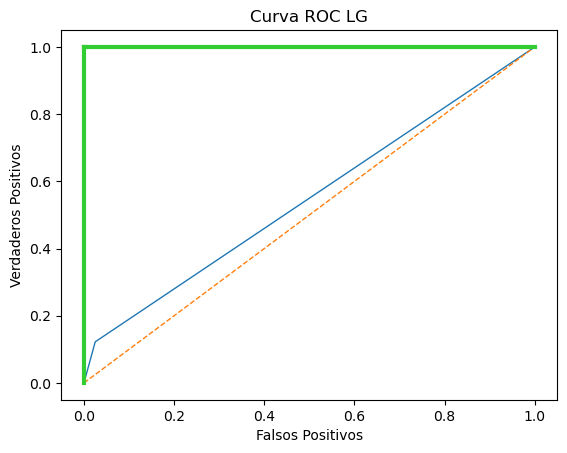

In [35]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test, y_LG_predict)

plt.title("Curva ROC LG")
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c="limegreen", lw=3), plt.plot([1, 1] , c="limegreen", lw=3)
plt.ylabel("Verdaderos Positivos")
plt.xlabel("Falsos Positivos");

## Modelo 2 - Arresto: Maquinas de Soporte Vectorial

In [36]:
grilla_SVC = GridSearchCV(SVC(), param_grid=parametros_SVC, cv=3, verbose=5)
grilla_SVC.fit(X_train, y_train)
y_SVC_predict = grilla_SVC.best_estimator_.predict(X_test)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV 1/3] END .............C=0.0001, gamma=1e-07;, score=0.755 total time=   0.4s
[CV 2/3] END .............C=0.0001, gamma=1e-07;, score=0.756 total time=   0.4s
[CV 3/3] END .............C=0.0001, gamma=1e-07;, score=0.756 total time=   0.4s
[CV 1/3] END ............C=0.0001, gamma=0.0001;, score=0.755 total time=   0.4s
[CV 2/3] END ............C=0.0001, gamma=0.0001;, score=0.756 total time=   0.4s
[CV 3/3] END ............C=0.0001, gamma=0.0001;, score=0.756 total time=   0.4s
[CV 1/3] END .............C=0.0001, gamma=0.001;, score=0.755 total time=   0.4s
[CV 2/3] END .............C=0.0001, gamma=0.001;, score=0.756 total time=   0.4s
[CV 3/3] END .............C=0.0001, gamma=0.001;, score=0.756 total time=   0.4s
[CV 1/3] END ..............C=0.0001, gamma=0.01;, score=0.755 total time=   0.4s
[CV 2/3] END ..............C=0.0001, gamma=0.01;, score=0.756 total time=   0.4s
[CV 3/3] END ..............C=0.0001, gamma=0.01

In [28]:
print("Mejores parámetros: ", grilla_LG.best_params_)
print("Mejor puntaje     : ", grilla_LG.best_score_)

Mejores parámetros:  {'C': 0.01, 'fit_intercept': True}
Mejor puntaje     :  0.7653150908981804


In [29]:
print(classification_report(y_test, y_SVC_predict))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3643
           1       0.00      0.00      0.00      1104

    accuracy                           0.77      4747
   macro avg       0.38      0.50      0.43      4747
weighted avg       0.59      0.77      0.67      4747



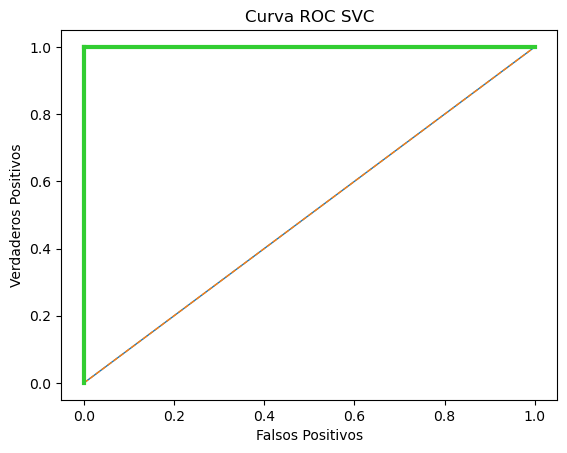

In [30]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test, y_SVC_predict)
plt.title("Curva ROC SVC")
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c="limegreen", lw=3), plt.plot([1, 1] , c="limegreen", lw=3)
plt.ylabel("Verdaderos Positivos")
plt.xlabel("Falsos Positivos");